In [13]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os


In [14]:
import unicodedata
import string

def findFiles(path): return glob.glob(path)


all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(all_categories)
print(category_lines['Italian'][:5])

['German', 'Czech', 'Italian', 'Vietnamese', 'Spanish', 'Russian', 'English', 'Portuguese', 'Scottish', 'Greek', 'Polish', 'French', 'Irish', 'Chinese', 'Arabic', 'Japanese', 'Korean', 'Dutch']
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [15]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(1, len(line), n_letters)
    for li, letter in enumerate(line):
        tensor[0][li][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([1, 5, 57])


In [16]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor.view(-1), line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Sowka
category = Korean / line = Hwang
category = Japanese / line = Kashiwagi
category = Irish / line = Neville
category = Greek / line = Tourna
category = Arabic / line = Antar
category = Korean / line = Mo
category = German / line = Heidrich
category = Spanish / line = Cabrera
category = Spanish / line = Castillion


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module): #1 recurrent block
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = torch.tanh(self.i2h(combined)) # h = tanh(W * [input, h])
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out[None, -1], hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

n_hidden = 128
# rnn = RNN(n_letters, n_hidden, n_categories)

rnn = Model(n_letters, n_categories, n_hidden, n_layers=1)

In [18]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)


def train(category_tensor, line_tensor):

    rnn.zero_grad()
    output, hidden = rnn(line_tensor) #recurrent training

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()



In [19]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 16s) 1.6934 Mclaughlin / Irish ✗ (Scottish)
10000 10% (0m 32s) 1.5002 Chevrolet / English ✗ (French)
15000 15% (0m 48s) 1.0885 Oomen / Dutch ✓
20000 20% (1m 5s) 2.9964 Cameron / Spanish ✗ (Scottish)
25000 25% (1m 21s) 1.9289 Franco / Portuguese ✗ (Spanish)
30000 30% (1m 38s) 0.6185 Mah / Chinese ✓
35000 35% (1m 54s) 1.6132 Wondracek / German ✗ (Czech)
40000 40% (2m 10s) 0.1792 Ron / Korean ✓
45000 45% (2m 26s) 0.9950 Ormsby / English ✓
50000 50% (2m 43s) 0.0630 Do / Vietnamese ✓
55000 55% (2m 59s) 0.4600 Leeuwenhoek / Dutch ✓
60000 60% (3m 16s) 0.7324 Ahn / Korean ✓
65000 65% (3m 32s) 0.0171 Vo / Vietnamese ✓
70000 70% (3m 49s) 0.1362 Ding / Chinese ✓
75000 75% (4m 5s) 1.9318 Assen / Japanese ✗ (Dutch)
80000 80% (4m 21s) 0.8566 Kranz / Dutch ✗ (German)
85000 85% (4m 37s) 1.6736 Ventura / Portuguese ✗ (Spanish)
90000 90% (4m 54s) 0.0581 Santos / Portuguese ✓
95000 95% (5m 10s) 0.1052 Aodha / Irish ✓
100000 100% (5m 25s) 0.0770 Hitomi / Japanese ✓


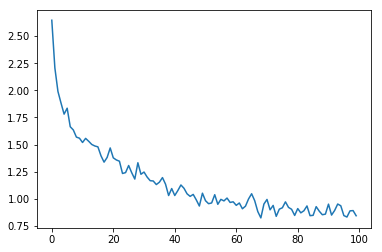

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

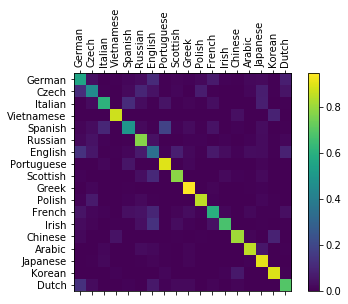

In [21]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line


# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, hidden = rnn(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [26]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        line_tensor = lineToTensor(input_line)
        output, hidden = rnn(line_tensor)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Shatoshi')
predict('hwan')
predict('Vu')



> Shatoshi
(6.64) Japanese
(3.69) Arabic
(3.46) Czech

> hwan
(7.03) Korean
(5.67) Chinese
(3.73) Vietnamese

> Vu
(11.84) Vietnamese
(5.23) Chinese
(3.43) Japanese
